In [1]:
%matplotlib inline

import gensim
import networkx as nx

In [2]:
model_file = 'ruwikiruscorpora_upos_cbow_300_20_2017.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(model_file, binary=True)

c:\python36\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Будем рассматривать семантическое поле "домашние животные"

In [3]:
start_nodes = ['кошка_NOUN', 'кот_NOUN', 'собака_NOUN', 'попугай_NOUN', 'петух_NOUN', 'корова_NOUN']
sem_field = nx.Graph()
sem_field.add_nodes_from(start_nodes)

In [4]:
def find_closest_neighbours(model, word, min_cos_dist=0.5, topn=100):
    if word not in model:
        raise Exception(f'This model does not contain word {word}')
    else:
        closest_neighbours = []
        for neighbour, cos_dist in model.most_similar(positive=[word], topn=topn):
            if cos_dist < min_cos_dist:
                break
            closest_neighbours.append((neighbour, cos_dist))
    return closest_neighbours


def add_neighbours(sem_field, model, word, depth=0, max_neighbours=100):
    closest_neighbours = find_closest_neighbours(model, word, topn=max_neighbours)
    for neighbour, cos_dist in closest_neighbours:
        if neighbour.endswith('_NOUN'):
            sem_field.add_edge(word, neighbour, weight=cos_dist)
            if depth:
                add_neighbours(sem_field, model, neighbour, depth - 1, max_neighbours)

In [5]:
for word in start_nodes:
    add_neighbours(sem_field, model, word, depth=1, max_neighbours=5)

In [6]:
print('Плотность графа –', nx.density(sem_field))
try:
    print('Диаметр графа –', nx.diameter(sem_field))
    print('Радиус графа –', nx.radius(sem_field))
except nx.NetworkXError:
    print('У графа больше одной компоненты связности, нельзя посчитать радиус и диаметр')
print('Коэффициент кластеризации –', nx.average_clustering(sem_field))
print('Коэффициент ассортативности –', nx.degree_pearson_correlation_coefficient(sem_field))

Плотность графа – 0.0355434039644566
У графа больше одной компоненты связности, нельзя посчитать радиус и диаметр
Коэффициент кластеризации – 0.16017316017316016
Коэффициент ассортативности – -0.345585128855


In [7]:
print('Центральный узел по degree centrality –', sorted(nx.degree_centrality(sem_field).items(), key=lambda x: x[1])[-1][0][:-5])
print('По betweenness centrality –', sorted(nx.betweenness_centrality(sem_field).items(), key=lambda x: x[1])[-1][0][:-5])
print('По closeness centrality –', sorted(nx.closeness_centrality(sem_field).items(), key=lambda x: x[1])[-1][0][:-5])
print('По eigencentrality –', sorted(nx.eigenvector_centrality(sem_field).items(), key=lambda x: x[1])[-1][0][:-5])

Центральный узел по degree centrality – цыпленок
По betweenness centrality – обезьянка
По closeness centrality – обезьянка
По eigencentrality – пес


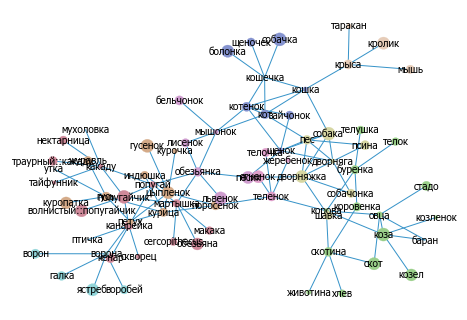

In [9]:
import matplotlib.pyplot as plt
from matplotlib import style

from networkx.algorithms.community import greedy_modularity_communities

style.use('seaborn-notebook')

mapping = {old_name: __import__('re').sub('_NOUN', '', old_name) for old_name in sem_field.nodes()}
sem_field = nx.relabel_nodes(sem_field, mapping)

pos = nx.kamada_kawai_layout(sem_field)

communities = greedy_modularity_communities(sem_field)
centrality = {word: nx.betweenness_centrality(sem_field)[word] * 1500 for word in sem_field.nodes()}

colors = ['#cf8a9a', '#9acf8a', '#d4aa88',
          '#8593cf', '#d6d6a2', '#cf9dcf',
          '#92d5d9', '#e6ccb8', '#de9eca']

for i, comm in enumerate(communities):
    nx.draw_networkx_nodes(comm, pos, node_color=colors[i], node_size=list(centrality.values())) 

nx.draw_networkx_edges(sem_field, pos, edge_color='#3894c9')
nx.draw_networkx_labels(sem_field, pos, font_size=10, font_family='Tahoma')
plt.axis('off') 
plt.show()

**Интерпретация**: граф в целом разбился ожидаемо, стартовые слова "кошка" и "кот" образовали одно коммьюнити, остальные – каждое свое. Также возникли новые коммьюнити (например, "дикие птицы" слева внизу или "крыса, таракан, кролик, мышь" справа вверху).

Ниже отдельно отрисованы компоненты связности, чтобы показать, что их действительно две, т.к. на основном графике не видно

In [10]:
graphs = list(nx.connected_component_subgraphs(sem_field))
len(graphs)

2

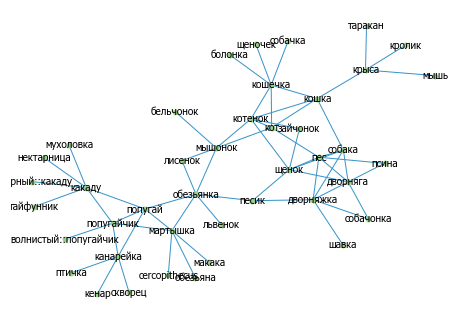

In [11]:
nx.draw_networkx_nodes(graphs[0], pos, node_color='#9acf8a', node_size=30) 
nx.draw_networkx_edges(graphs[0], pos, edge_color='#3894c9')
nx.draw_networkx_labels(graphs[0], pos, font_size=10, font_family='Tahoma')
plt.axis('off') 
plt.show()

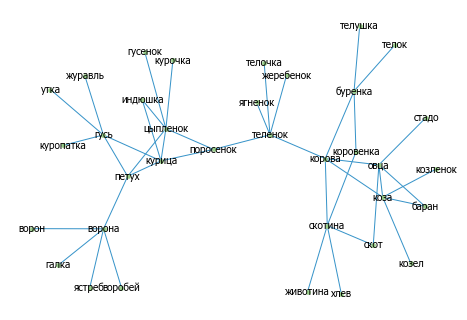

In [12]:
nx.draw_networkx_nodes(graphs[1], pos, node_color='#9acf8a', node_size=20) 
nx.draw_networkx_edges(graphs[1], pos, edge_color='#3894c9')
nx.draw_networkx_labels(graphs[1], pos, font_size=10, font_family='Tahoma')
plt.axis('off') 
plt.show()